<a href="https://colab.research.google.com/github/kejerial/healthcare-model/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
expenditure_url = 'https://docs.google.com/spreadsheets/d/1ZQV-MAifKUrxIoaBd4qI8dEJnBdtX3g0-cLEPP67ptI/export?format=csv'
expenditure = pd.read_csv(expenditure_url)

uhci_url = 'https://docs.google.com/spreadsheets/d/1RROZgjf2eXI-DIEwrUBvqXFt6MChluJ7fMHz4Qq6Y-0/export?format=csv'
uhci = pd.read_csv(uhci_url)

hepb_url = 'https://docs.google.com/spreadsheets/d/1jnIQjAk1vG2PbizP0dcQbiGMlkoqqPwCKGTBEQgCdfE/export?format=csv'
hepb = pd.read_csv(hepb_url)

air_pollution_url = 'https://docs.google.com/spreadsheets/d/12oZ4JXtuk9E5K_ENLE60glcguSaRCeUe_ZO1C2rC7hM/export?format=csv'
air_pollution = pd.read_csv(air_pollution_url)

disease_url = 'https://docs.google.com/spreadsheets/d/1B76dmf4OjBaMC2uRhafj7euaqzdRB1G5owlbrqzo3nQ/export?format=csv'
disease = pd.read_csv(disease_url)

ozone_url = 'https://docs.google.com/spreadsheets/d/1QhJTM1r0vkAj_7y7uNp0oAo8Z9Y0TUYWcqrKkc0Hun8/export?format=csv'
ozone = pd.read_csv(ozone_url)

expectency_url = 'https://docs.google.com/spreadsheets/d/10KvXg_dwxufK5z7XWWxKqKgDL0mB-j5njsvyjxkqdfo/export?format=csv'
expectency = pd.read_csv(expectency_url)

youth_deaths_url = 'https://docs.google.com/spreadsheets/d/1rGJuPxZVlr7pc4XRGYz5-UC4nwQQRO7XhFuYryjlPuU/export?format=csv'
youth_deaths = pd.read_csv(youth_deaths_url)

contraception_url = 'https://docs.google.com/spreadsheets/d/14X8YDrFZrfQWA4T-SC-TUTepmqQdnoKX5CmFjolhC0g/export?format=csv'
contraception = pd.read_csv(contraception_url)

tobacco_url = 'https://docs.google.com/spreadsheets/d/18Cql5rTLG5sjhvH-50lyf1IU2eDbM3Vu_v4F5goUTfI/export?format=csv'
tobacco = pd.read_csv(tobacco_url)

In [ ]:
combined_dataset = expenditure.merge(uhci, on=['Entity', 'Code', 'Year'], how='left') \
    .merge(hepb, on=['Entity', 'Code', 'Year'], how='left') \
    .merge(air_pollution, on=['Entity', 'Code', 'Year'], how='left') \
    .merge(disease, on=['Entity', 'Code', 'Year'], how='left') \
    .merge(ozone, on=['Entity', 'Code', 'Year'], how='left') \
    .merge(expectency, on=['Entity', 'Code', 'Year'], how='left') \
    .merge(youth_deaths, on=['Entity', 'Code', 'Year'], how='left') \
    .merge(contraception, on=['Entity', 'Code', 'Year'], how='left') \
    .merge(tobacco, on=['Entity', 'Code', 'Year'], how='left')

column_rename_mapping = {
    "Current health expenditure (CHE) as percentage of gross domestic product (GDP) (%)" : "expenditure",
    "UHC Index" : "uhci",
    "HepB3 (% of one-year-olds immunized)" : "hepb3",
    "Deaths that are from all causes attributed to air pollution, in both sexes aged all ages" : "air_pollution_death",
    "Deaths from Infectious diseases" : "disease_death",
    "Deaths that are from all causes attributed to ambient ozone pollution" : "ozone_pollution_death",
    "Life expectancy at birth" : "life_expectency",
    "Under fifteen mortality - Number of deaths " : "child_mortality",
    "Proportion of women of reproductive age (aged 15-49 years) who have their need for family planning satisfied with modern methods (% of women aged 15-49 years)" : "contraception",
    "Deaths that are from all causes attributed to smoking" : "smoking"
}
combined_dataset = combined_dataset.rename(columns=column_rename_mapping)

combined_dataset = combined_dataset.sort_values(by=['Entity', 'Code', 'Year'])

# ignore country and world data
combined_dataset = combined_dataset[(combined_dataset['Code'] != 'OWID_WRL') & (combined_dataset['Code'].notnull())]

combined_dataset = combined_dataset.reset_index(drop=True)

<Axes: >

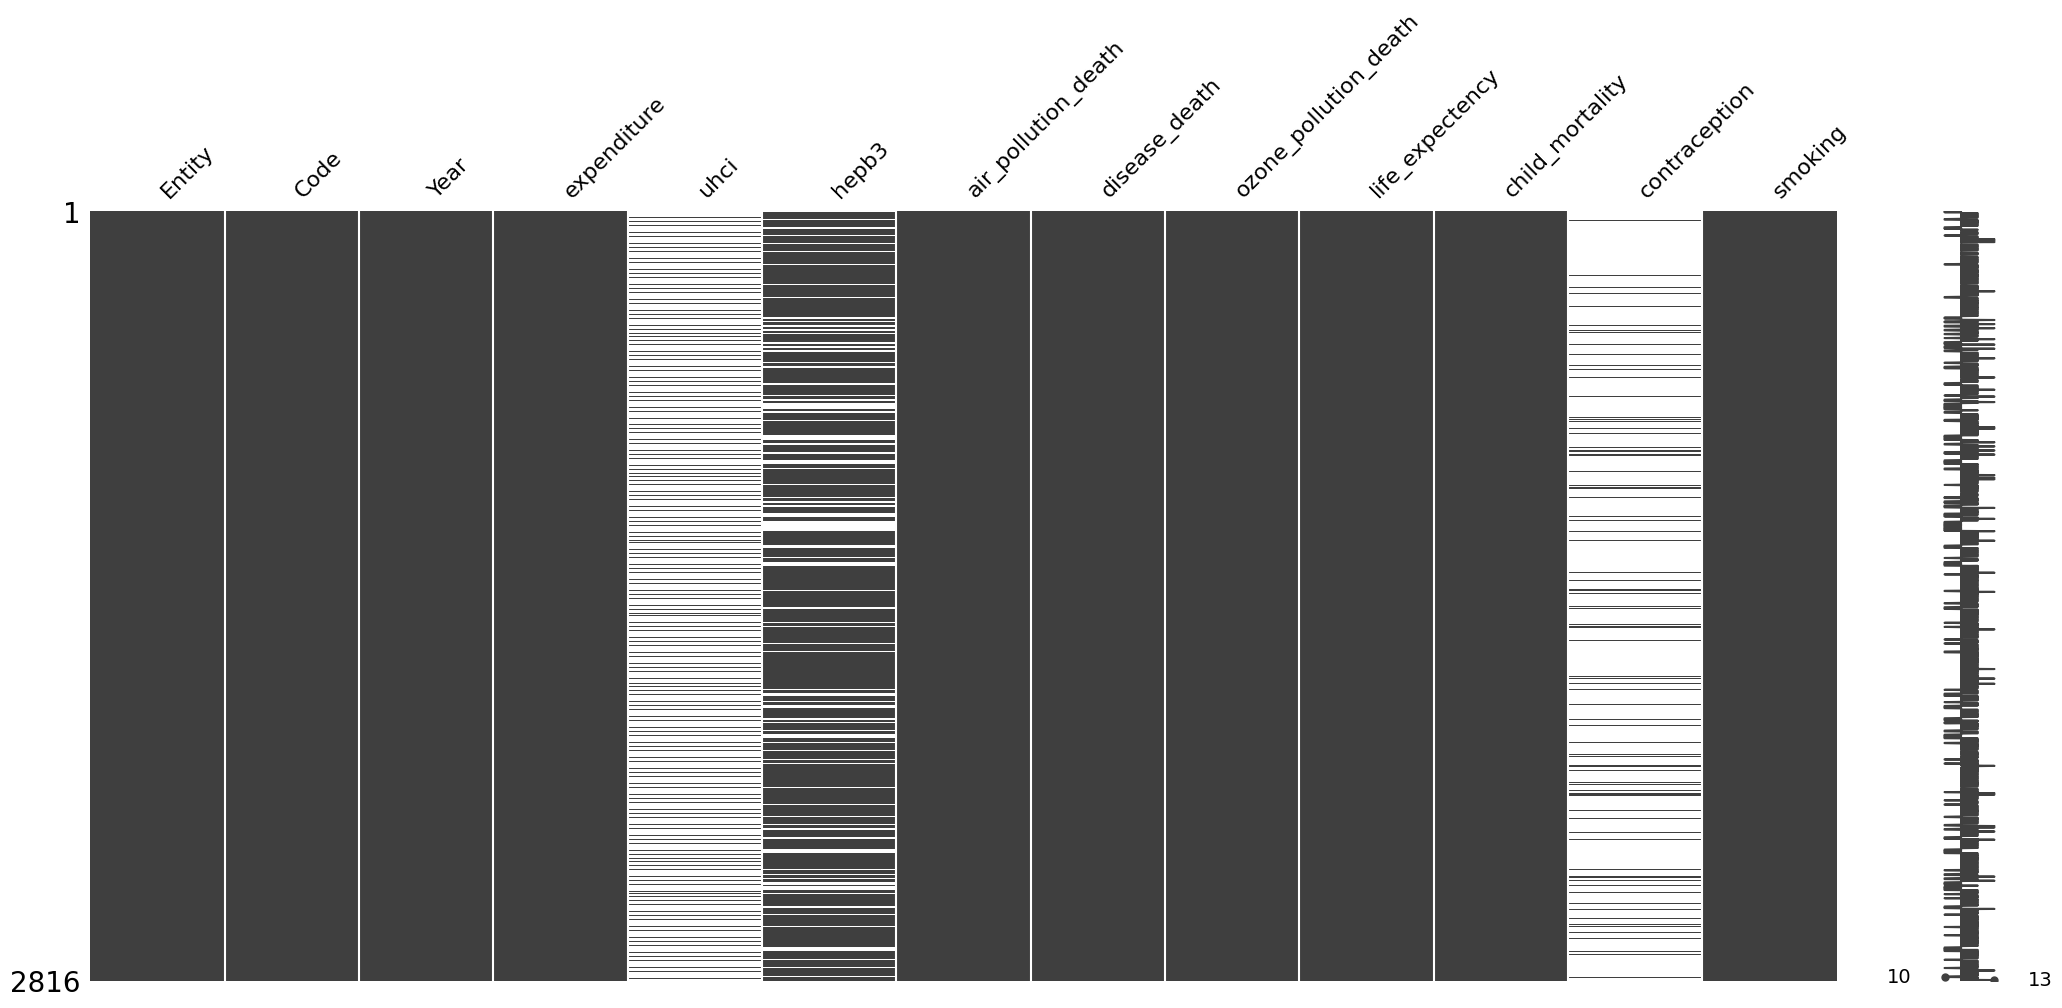

In [ ]:
import missingno as msno
msno.matrix(combined_dataset)

<Axes: >

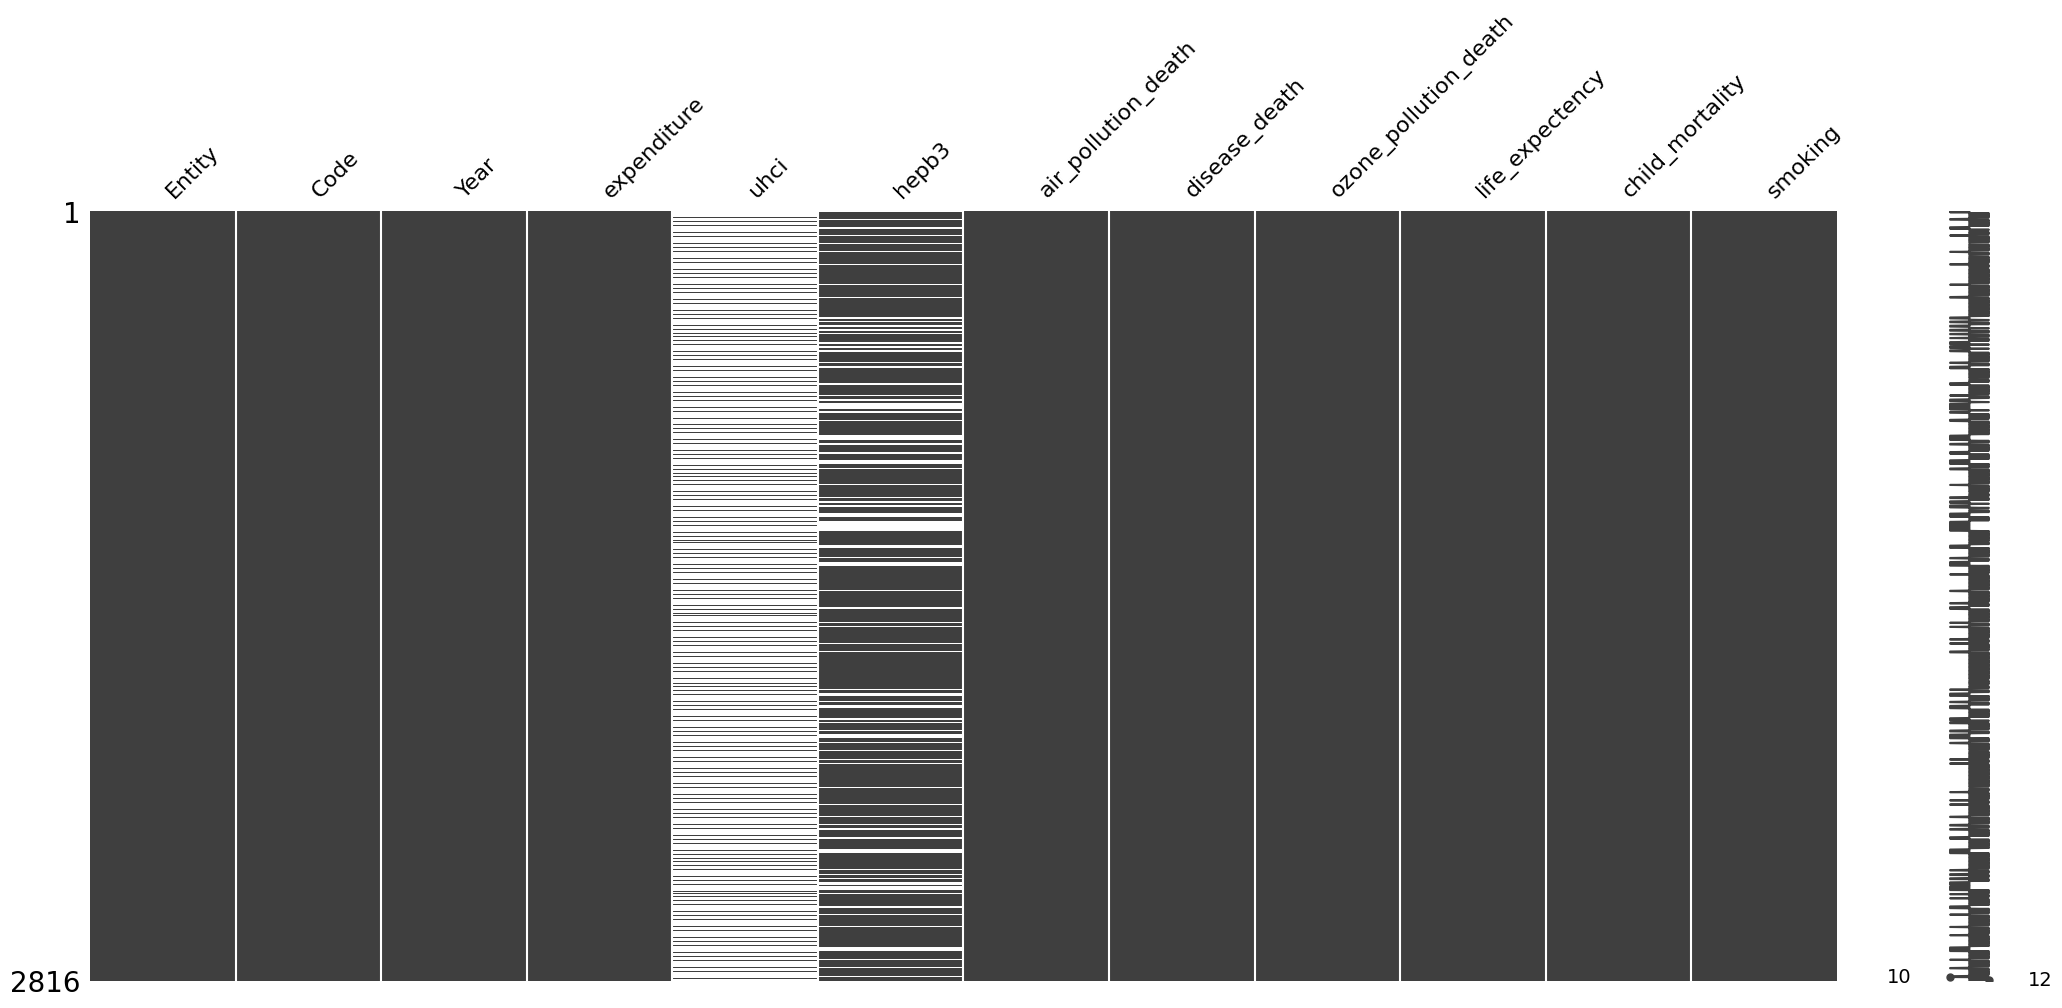

In [ ]:
# drop to avoid overfitting
clean_data = combined_dataset.drop(["contraception"], axis=1)
msno.matrix(clean_data)

In [ ]:
code_to_region_url = 'https://docs.google.com/spreadsheets/d/1ZQV-MAifKUrxIoaBd4qI8dEJnBdtX3g0-cLEPP67ptI/export?format=csv'
code_to_region = pd.read_csv(code_to_region_url)

hepb_regions = hepb[hepb['Code'].isnull()]
combined_dataset = combined_dataset.sort_values(by=['Entity', 'Year'])
hepb_regions = hepb_regions.reset_index(drop=True)

hepb_regions.head(180)

,Entity,Code,Year,HepB3 (% of one-year-olds immunized)
0,African Region (WHO),NaN,1985,0
1,African Region (WHO),NaN,1986,0
2,African Region (WHO),NaN,1987,0
3,African Region (WHO),NaN,1988,0
4,African Region (WHO),NaN,1989,0
...,...,...,...,...
175,Western Pacific Region (WHO),NaN,2010,92
176,Western Pacific Region (WHO),NaN,2011,93
177,Western Pacific Region (WHO),NaN,2012,93
178,Western Pacific Region (WHO),NaN,2013,90


In [ ]:
# found 2nd degree polynomial to be a good predictor
degree = 2

predictions_df = pd.DataFrame()

# Iterate over each unique country code
for country_code in clean_data['Code'].unique():
    # Subset the dataset for the current country
    df = clean_data[clean_data['Code'] == country_code]

    # Create a new DataFrame to store the predicted values for 2015
    predictions = pd.DataFrame(columns=['Entity', 'Code', 'Year'])

    # Iterate over each variable
    for column in df.columns[3:]:
        if column != 'expenditure':
            x = df['Year']
            y = df[column]

            if column == 'uhci':
                # Filter out NaN values
                non_nan_mask = ~np.isnan(y)
                x_non_nan = x[non_nan_mask].values.reshape(-1, 1)
                y_non_nan = y[non_nan_mask].values.reshape(-1, 1)

                # Perform linear regression for UHCI
                if len(x_non_nan) > 0:
                    # Perform linear regression for UHCI
                    lr = LinearRegression()
                    lr.fit(x_non_nan, y_non_nan)
                    predicted_value_2015 = lr.predict([[2015]])[0][0]
                else:
                    # Skip if no samples
                    predicted_value_2015 = np.nan
            else:
                # Perform polynomial regression for other variables
                coeffs = np.polyfit(x, y, degree)
                poly = np.poly1d(coeffs)
                predicted_value_2015 = poly(2015)
            predictions[column] = [predicted_value_2015]

    # Add the country information to the predictions DataFrame
    predictions['Entity'] = df['Entity'].iloc[0]
    predictions['Code'] = df['Code'].iloc[0]
    predictions['Year'] = 2015

    # Append the predictions DataFrame to the combined dataset
    predictions_df = pd.concat([predictions_df, predictions], ignore_index=True)

predictions_df.head(50)

,Entity,Code,Year,uhci,hepb3,air_pollution_death,disease_death,ozone_pollution_death,life_expectency,child_mortality,smoking
0,Afghanistan,AFG,2015,31.359000,NaN,3.736483e+04,48500.657342,384.048390,63.114685,90181.489511,8.749050e+03
1,Albania,ALB,2015,65.390567,98.200000,2.129488e+03,546.336264,27.215338,78.461978,453.694506,3.762053e+03
2,Algeria,DZA,2015,72.331743,NaN,1.988704e+04,9057.347253,538.670814,75.377363,28396.101099,1.915890e+04
3,Andorra,AND,2015,77.822683,100.226374,1.476500e+01,24.296703,3.184799,82.873407,1.648352,9.210316e+01
4,Angola,AGO,2015,35.827707,NaN,1.537315e+04,78667.556044,111.277169,60.941978,109313.854945,6.779480e+03
5,Antigua and Barbuda,ATG,2015,83.465767,NaN,2.926514e+01,39.545055,0.011485,78.124396,10.778022,3.231392e+01
6,Argentina,ARG,2015,81.184930,NaN,1.434474e+04,40994.228572,460.021669,76.967253,10501.580220,4.790185e+04
7,Armenia,ARM,2015,67.645933,89.518681,3.314040e+03,716.389011,136.790006,74.332747,772.835165,4.524038e+03
8,Australia,AUS,2015,85.517173,NaN,1.757827e+03,4212.417582,73.368302,82.747033,1420.375824,1.809011e+04
9,Austria,AUT,2015,87.400923,86.641758,2.996142e+03,1245.810989,242.341918,81.384176,361.380220,1.242068e+04


In [ ]:
X = clean_data.drop(columns=['Entity', 'Year', 'expenditure'])
y = clean_data['expenditure']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing for numerical features
numeric_features = ['uhci', 'hepb3', 'air_pollution_death', 'disease_death',
                    'ozone_pollution_death', 'life_expectency', 'child_mortality','smoking']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical features
categorical_features = ['Code']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Fit preprocessing to training data
preprocessor.fit(X_train)

# Preprocess training and testing data
X_train_processed = preprocessor.transform(X_train).toarray()
X_test_processed = preprocessor.transform(X_test).toarray()

# Define the neural network architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_processed.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=["mean_absolute_error"])

# Train the model
model.fit(X_train_processed, y_train, epochs=20, batch_size=32, validation_split=0.15)

# Evaluate the model on the test data
test_loss, test_mae = model.evaluate(X_test_processed, y_test)
print("Test Loss:", test_loss)
print("Mean Absolute Error:", test_mae)

Epoch 1/20
60/60 [==============================] - 2s 9ms/step - loss: 31.2308 - mean_absolute_error: 4.6327 - val_loss: 13.0965 - val_mean_absolute_error: 2.4525
Epoch 2/20
60/60 [==============================] - 0s 5ms/step - loss: 8.6312 - mean_absolute_error: 1.9488 - val_loss: 7.3944 - val_mean_absolute_error: 1.6894
Epoch 3/20
60/60 [==============================] - 0s 8ms/step - loss: 5.8584 - mean_absolute_error: 1.5131 - val_loss: 5.3911 - val_mean_absolute_error: 1.2938
Epoch 4/20
60/60 [==============================] - 0s 5ms/step - loss: 4.2802 - mean_absolute_error: 1.1725 - val_loss: 4.1229 - val_mean_absolute_error: 1.0389
Epoch 5/20
60/60 [==============================] - 0s 4ms/step - loss: 3.2479 - mean_absolute_error: 0.9564 - val_loss: 3.3663 - val_mean_absolute_error: 0.8344
Epoch 6/20
60/60 [==============================] - 0s 3ms/step - loss: 2.5540 - mean_absolute_error: 0.7947 - val_loss: 2.8932 - val_mean_absolute_error: 0.7729
Epoch 7/20
60/60 [========

## Neural Network Hyperparameter Tuning
epochs=20, batch_size=16  0.6642

epochs=20, batch_size=32  0.6502

epochs=20, batch_size=64  0.6637

epochs=20, batch_size=32, validation_split=0.15 0.6447

epochs=20, batch_size=32, validation_split=0.1 0.6545

So, epochs=20, batch_size=32, validation_split=0.15 yielded the lowest MAE of 0.6447. However, it is important to note that with a small dataset and low validation_split as such, it can lead to variability in model performance.



